<a href="https://colab.research.google.com/github/sunil448832/Machine-Learning/blob/main/Convolution_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Image preprocessing**

In [2]:
def preprocess(img):
  img = img.convert('RGB')
  img = torch.Tensor(np.array(img))
  return img.permute(2,0,1).float()/255.0  # convert (H,W,C) to (C,H,W) and then normalise by 255


In [ ]:

train_dataset = torchvision.datasets.MNIST('/content/files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([preprocess]))

test_dataset = torchvision.datasets.MNIST('/content/files/', train=False,download=True,
                            transform=torchvision.transforms.Compose([preprocess]))
size=len(train_dataset.targets)


In [4]:
# splitting training set into 70% triaining set and 30% validation set 

train_indices=torch.utils.data.Subset(train_dataset,range(int(.7*size))).indices
val_indices=torch.utils.data.Subset(train_dataset,range(int(.7*size),size)).indices


In [5]:

class MyDataset(Dataset):
  def __init__(self,dataset,indices,model_type='ae'):
    self.dataset=dataset
    self.indices=list(indices)
    self.model_type=model_type
    
  def __getitem__(self, index):
    subset=torch.utils.data.Subset(self.dataset,[self.indices[0]+index])
    image,target=next(iter(DataLoader(subset,batch_size=1)))
    image=image.squeeze(0)
    target=target.squeeze(0)
    
    if self.model_type=='ae': # if dataset used for auto encoder
       return image,image
    else:                     # dataset used for Classification
      return image,target
    
  def __len__(self):
    return len(self.indices)

def show(img):
  plt.figure(figsize=(20,50)) 
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')



# **First Batch of Training set**

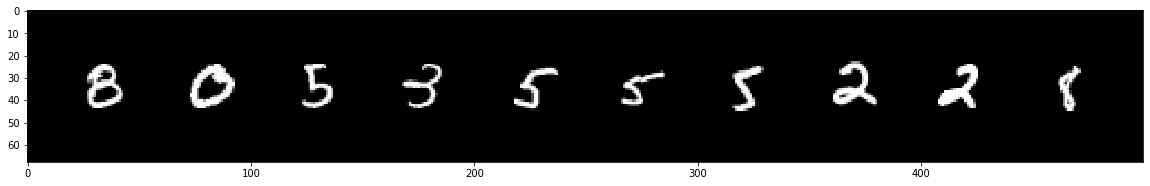

In [6]:
x,y = next(iter(DataLoader(train_dataset,batch_size=10,shuffle=True)))
grid = torchvision.utils.make_grid(x,nrow=10, padding=20)
show(grid)

# **Auto Encoder Model**

In [7]:

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    pool = nn.MaxPool2d(kernel_size=2, stride=2) 

    #Encoder
    self.encoder=nn.Sequential(nn.Conv2d(3, 8, kernel_size=3,stride=1,padding=1),nn.ReLU(inplace=True),pool,
                               nn.Conv2d(8, 16, kernel_size=3,stride=1,padding=1),nn.ReLU(inplace=True),pool,
                               nn.Conv2d(16, 32, kernel_size=3,stride=1,padding=1),nn.ReLU(inplace=True),pool,
                               )
    
    #Decoder
    self.decoder=nn.Sequential(nn.ConvTranspose2d(32, 16,kernel_size=2, stride=2,output_padding=1),nn.ReLU(inplace=True),
                               nn.ConvTranspose2d(16, 8,kernel_size=2, stride=2),nn.ReLU(inplace=True),
                               nn.ConvTranspose2d(8, 3,kernel_size=2, stride=2),nn.Sigmoid()
                               )
    self.criterion=nn.MSELoss()

  def forward(self, x):
    x=self.encoder(x)
    x=self.decoder(x)   
    return x
  # Auto Encoder loss function  
  def loss(self,x,y):
    x=x.view(x.size(0),-1).float()
    y=y.view(y.size(0),-1).float()
    return self.criterion(x,y)


# **Training using FastAI Learner and saving the runs in to Weights and Biases**

In [8]:
!pip install -qqq wandb
!pip install -qqqU fastai
import wandb
from fastai.callback.wandb import *
from fastai.vision.all import *
from fastai.data.core import DataLoaders
wandb.login()

     |████████████████████████████████| 1.8MB 12.5MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 163kB 42.2MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 133kB 53.9MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
     |████████████████████████████████| 194kB 11.8MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [10]:
train_dataset_ae=MyDataset(train_dataset,train_indices,model_type='ae')
val_dataset_ae=MyDataset(train_dataset,val_indices,model_type="ae")


In [ ]:
wandb.init(project='AutoEncoder')

# **Auto Encoder Training**

In [14]:
dls = DataLoaders.from_dsets(train_dataset_ae, val_dataset_ae).to(device)
train=True
if train:
  model=AutoEncoder().to(device)
  learn = Learner(dls,model,model.loss,cbs=WandbCallback(log_model=True))
  learn.fit_one_cycle(10, 1e-3)

WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'MyDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,time
0,0.131409,0.113863,00:45
1,0.041812,0.040105,00:45
2,0.026151,0.025495,00:46
3,0.017742,0.017774,00:45
4,0.015951,0.016190,00:46
5,0.015059,0.015172,00:46
6,0.014301,0.014525,00:46
7,0.013888,0.014165,00:46
8,0.013780,0.014036,00:46
9,0.013782,0.013996,00:46


# **Test Set Samples**

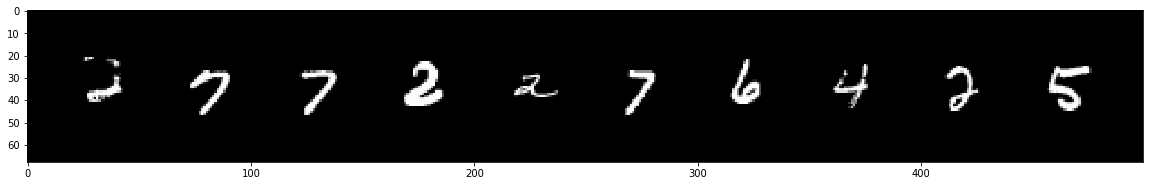

In [15]:
x_test,y_test = next(iter(DataLoader(test_dataset,batch_size=10,shuffle=True)))
grid = torchvision.utils.make_grid(x_test,nrow=10, padding=20)
show(grid)


# **Auto Encoder Reconstruction of Test Sample**

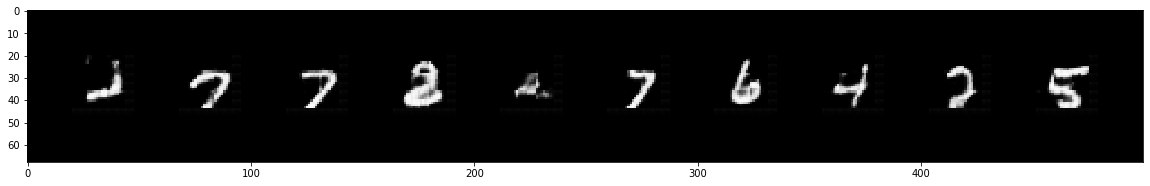

In [22]:
with torch.no_grad():
  x_test_pred=model(x_test).cpu()
  grid = torchvision.utils.make_grid(x_test_pred,nrow=10, padding=20)
  show(grid)


# **Classifier Model to Classify MNIST data using Above Autoencoder's Encoder part as Feature Extarcter and final Linear Layer as Classifier**

In [28]:
class Classifier(nn.Module):
  def __init__(self,model):
    super(Classifier,self).__init__()
    self.feature=model.encoder
    self.output= nn.Linear(3*3*32,10)
  def forward(self,x):
    x=self.feature(x).view(x.size(0),-1)
    return self.output(x)



In [29]:
train_dataset_c=MyDataset(train_dataset,train_indices,model_type='c')
val_dataset_c=MyDataset(train_dataset,val_indices,model_type="c")


In [ ]:
wandb.init(project='Classifier')

# **Training Classifer by freezing the pretrained Encoder**

In [33]:


dls = DataLoaders.from_dsets(train_dataset_c, val_dataset_c).to(device)

#spiliter to split models used to freeze any section
splitter=lambda model:[params(model.feature),params(model.output)]

classifier=Classifier(model).to(device)
learn = Learner(dls,classifier,
                loss_func=CrossEntropyLossFlat(),
                metrics=accuracy,
                splitter=splitter,
                cbs=WandbCallback(log_model=True))

In [34]:
learn.freeze_to(0) # freeze the features Extracter(Encoder)
learn.fit_one_cycle(4, 1e-2) # train upto 4 epochs with learning rate of 1e-2

WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'MyDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.147570,0.107419,0.967167,00:41
1,0.083692,0.095730,0.971000,00:41
2,0.044627,0.053737,0.984444,00:40
3,0.017849,0.044054,0.987056,00:41


In [36]:
learn.unfreeze()                    # unfreeze Encoder and  train whole network     
learn.fit_one_cycle(4, slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.015309,0.044882,0.987444,00:40
1,0.012967,0.043596,0.987222,00:41
2,0.012658,0.043416,0.987778,00:41
3,0.010385,0.043284,0.987944,00:41
